In [1]:
# Set up
# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn as sns


COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral":"Adipose.V",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "SkinUnexposed",
    "Skin-SunExposed":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]
#%store -r    #Assuming you ran gtex_variables.ipynb
#%pylab inline


# Path to data
RESDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
# Output path
OUTPATH = "pdfs"
PREFIX = "Figure1" # Keep as a variable in case we move things around!

# COLORS SHORTEN  TISSUES (Stored these variables in the notebook named gtex_variables)

#function
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

# Load data 
NGESTR = pd.read_csv('/storage/szfeupe/Runs/GTEx_estr/2016_estrs_table.csv',sep=',')

alldata = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv', sep='\t')
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(RESDIR, t, "Lin_Reg_Out"), sep="\t")
    # Reformat gene names and start coords
    data[t]["gene"] = data[t]["gene"].apply(lambda x: x.split(".")[0])
    data[t]["str.start"] = (data[t]["str.start"] + 1).apply(int)
data["permuted"] = pd.read_csv(os.path.join(RESDIR, "WholeBlood","Lin_Reg_Out_perm"), sep="\t")
NGESTR['str.id'] = NGESTR['str.start'].apply(lambda x: 'STR_'+str(int(x)-1))
data["LCL"] = NGESTR

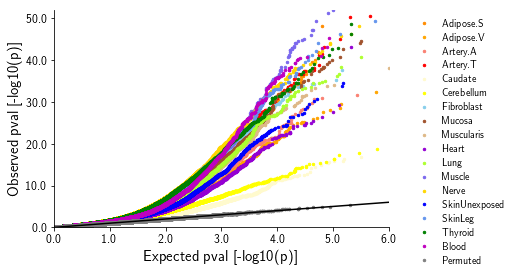

In [2]:
TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    unif = sorted(list(np.random.uniform(low=0, high=1, size=data[t].shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(data[t]["p.wald"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
fig.savefig(os.path.join(OUTPATH, "%s_qqplot.png"%PREFIX))
plt.show()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


WholeBlood (1419, 23) red:  (1057, 23) grey:  (362, 23)
(0.5885969754856596, 4.814192009490187e-133)


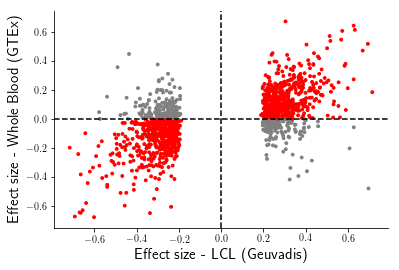

In [3]:
for t in TISSUES:
    wbestr = data[t].copy()
    merged = pd.merge(wbestr, NGESTR, on=["chrom","str.start","gene"])
    merged = merged[merged["signif.estr"]]
    #print(t, wbestr.shape, merged.shape[0])
merged["color"] = merged.apply(lambda x: ["gray","red"][np.sign(x["beta_x"])==np.sign(x["beta_y"])], 1)
print(t, merged.shape, 'red: ',merged.loc[merged['color']=='red'].shape, 'grey: ',merged.loc[merged['color']=='gray'].shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.scatter((merged["beta_y"]), merged["beta_x"], color=list(merged["color"]), s=8)
ax.grid(b=False)
ax.set_facecolor("white")
ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
#ax.set_xticklabels(ax.get_xticks(), size=10)
#ax.set_yticklabels(ax.get_yticks(), size=10);
ax.set_xlabel("Effect size - LCL (Geuvadis)", size=15)
ax.set_ylabel("Effect size - Whole Blood (GTEx)", size=15);
print(str(scipy.stats.pearsonr(merged["beta_y"], merged["beta_x"])))
fig.savefig(os.path.join(OUTPATH, "%s_effsize.pdf"%PREFIX))
plt.show()

In [4]:
master = {} # Map of tissue -> master data. Include all loci for comparisons below
for t in TISSUES:
    df = pd.read_csv(os.path.join(RESDIR, t, "Master.table"), sep="\t")
    df = df[~np.isnan(df["str.start"])]
    df["str.start"] = (df["str.start"] + 1).apply(int)
    df["gene"] = df["gene"].apply(lambda x: x.split(".")[0])
    df["significant"] = (df["significant"]==1)
    df["signif_%s"%t] = df["significant"]
    df["beta_%s"%t] = df["beta"]
    master[t] = df

In [5]:
# Figure 1 - pairwise tissue comparison (Using pearson)
#with Brains
master['LCL'] = NGESTR
ALLTISSUES =["Artery-Aorta","Artery-Tibial","Adipose-Subcutaneous","Adipose-Visceral","Esophagus-Mucosa","Esophagus-Muscularis","Thyroid","Heart-LeftVentricle","Lung","Nerve-Tibial","Skin-NotSunExposed","Skin-SunExposed","Muscle-Skeletal","Brain-Caudate","Brain-Cerebellum","Cells-Transformedfibroblasts", "WholeBlood","LCL"]
#sorted([item for item in list(SHORTEN.keys()) if item != "permuted"])
pdata = np.zeros((len(ALLTISSUES), len(ALLTISSUES)))
pvdata = np.zeros((len(ALLTISSUES), len(ALLTISSUES)))
master["LCL"]["signif_LCL"] = master["LCL"]["signif.estr"]
master["LCL"]["significant"] = master["LCL"]["signif.estr"]
master["LCL"]['beta_LCL'] = master["LCL"]['beta']
for i in range(len(ALLTISSUES)):
    for j in range(i+1):
        t1 = ALLTISSUES[i]
        t2 = ALLTISSUES[j]
        d = pd.merge(master[t1], master[t2], on=["chrom","str.start","gene", 'str.id'])
        if t1==t2: d = d[(d["significant_x"]) | (d["significant_y"])]
        if t1==t2: pdata[i][j] = scipy.stats.pearsonr(d["beta_x"], d["beta_y"])[0]
        if t1!=t2: d = d[(d["signif_%s"%t1]) | (d["signif_%s"%t2])]
        if t1!=t2: pdata[i][j] = scipy.stats.pearsonr(d["beta_%s"%t1], d["beta_%s"%t2])[0]

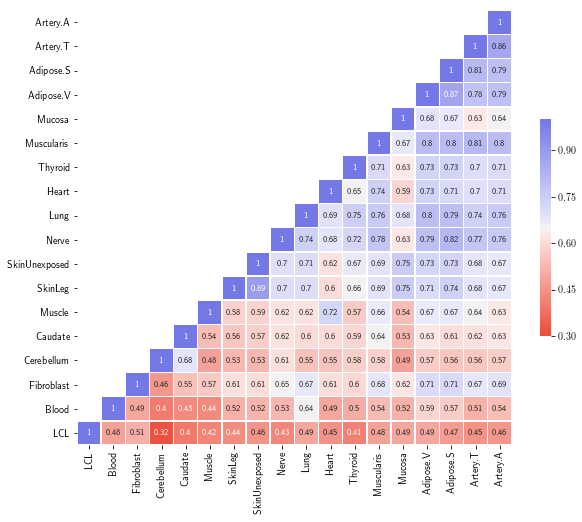

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)
mask = np.zeros_like(pdata, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
for i in range(len(ALLTISSUES)): mask[i][i] = False
sns.heatmap(pdata, mask=mask, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.3, vmax=1, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=[SHORTEN[t] for t in ALLTISSUES], 
           yticklabels=[SHORTEN[t] for t in ALLTISSUES]);
ax.invert_xaxis();
fig.savefig(os.path.join(OUTPATH,"%s_pairwisetissue.pdf"%PREFIX))
plt.show()

In [ ]:
pdata2 = pd.DataFrame(pdata)
pdata2.columns = ALLTISSUES
pdata1 = pdata2[T_sort]

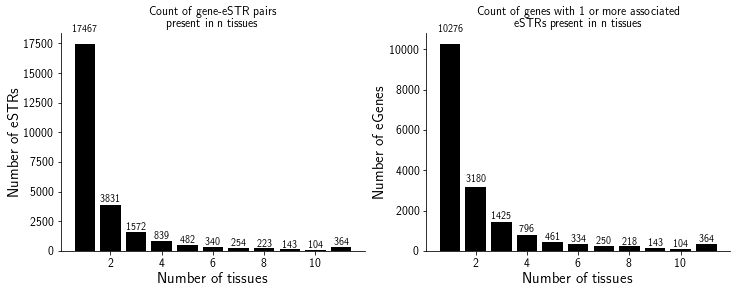

In [9]:
#eSTR count... Here same gene can have different eSTRs in different tissues
w = 0.25
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
counts = []
for i in range(1, 11):
    counts.append(alldata.loc[alldata["E.tissues"]==i].shape[0])
counts.append(len(set(list(alldata.loc[alldata["E.tissues"]>i]['gene']))))
countsbar = ax.bar(range(1, 12), counts, color="black")
#countsbar = ax.bar(range(1, 11), counts, color="black")
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.set_xlabel("Number of tissues", size=15)
ax.set_ylabel("Number of eSTRs", size=15);
ax.set_title("Count of gene-eSTR pairs \n present in n tissues")
# Add text
autolabel(countsbar)

#eGenes count... Here we count only genes affected by eSTRs
w = 0.25
ax = fig.add_subplot(122)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
counts = []
for i in range(1, 11):
    counts.append(len(set(list(alldata.loc[alldata["E.tissues"]==i]['gene']))))

counts.append(len(set(list(alldata.loc[alldata["E.tissues"]>i]['gene']))))
countsbar = ax.bar(range(1, 12), counts, color="black")

ax.set_xticklabels([int(x) for x in ax.get_xticks()]+['>10'], size=12);
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.set_xlabel("Number of tissues", size=15)
ax.set_ylabel("Number of eGenes", size=15);   autolabel(countsbar)
ax.set_title("Count of genes with 1 or more associated\n eSTRs present in n tissues")
fig.savefig(os.path.join(OUTPATH,"%s_tissuesperestr.pdf"%PREFIX))
plt.show()

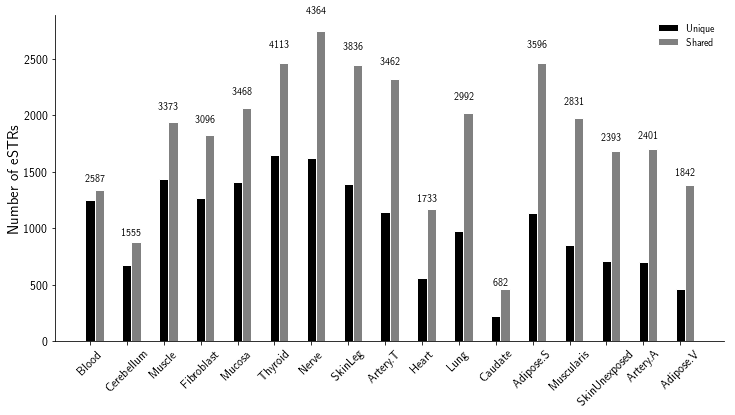

In [10]:
unique = []
shared = []
for t in TISSUES:
    t1 = SHORTEN[t]
    d = alldata[alldata["eSTR.%s"%t1]==1]
    total = d.shape[0]
    s = d[d["E.tissues"]>1].shape[0]
    u = total-s
    unique.append(u)
    shared.append(s)
d = pd.DataFrame({"unique": unique, "shared": shared, "tissue": TISSUES})
d["perc.unique"] = d.apply(lambda x: x["unique"]*1.0/(x["unique"]+x["shared"]), 1)
d["total"] = d["shared"]+d["unique"]
d = d.sort_values("perc.unique", ascending=False)
xvals = np.array(range(len(TISSUES)))
w = 0.25
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
bars1 = ax.bar(xvals, d["unique"], color="black", edgecolor="white", width=w, label="Unique")
bars2 = ax.bar(xvals+w, d["shared"], color="gray", edgecolor="white", width=w, label="Shared")
ax.set_xticks(xvals)
ax.set_xticklabels([SHORTEN[x] for x in d["tissue"]], size=12, rotation=45);
ax.set_ylabel("Number of eSTRs", size=15)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.legend(loc="upper right", frameon=False);

# Add text
i = 0
for i in range(len(TISSUES)):
    height = max([bars1[i].get_height(), bars2[i].get_height()])
    label = d["total"].values[i]
    ax.text(bars1[i].get_x() + bars1[i].get_width()/2.+w/2, 1.05*height, "%d"%label, ha="center", va="bottom")
    i+=1
fig.savefig(os.path.join(OUTPATH,"Suppl_%s_sharedestrpertissues.pdf"%PREFIX))
plt.show()

In [21]:
# Figure 1 - pairwise tissue comparison (mean)
#ALLTISSUES = ALLTISSUES + ["LCL"]
#ALLTISSUES = ["Esophagus-Mucosa","Muscle-Skeletal","Artery-Tibial","Adipose-Subcutaneous","Lung","Cells-Transformedfibroblasts","WholeBlood","LCL"]
pdata2 = np.zeros((len(ALLTISSUES), len(ALLTISSUES)))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]
for i in range(len(ALLTISSUES)):
    for j in range(i+1):
        t1 = ALLTISSUES[i]
        t2 = ALLTISSUES[j]
        d = pd.merge(master[t1], master[t2], on=["str.start","gene"])
        d = d[(d["significant_x"]) | (d["significant_y"])]
        pdata2[i][j] = np.mean(d.apply(lambda x: np.sign(x["beta_x"]) == np.sign(x["beta_y"]), 1))